# <center> TP4 : Reconnaissance de Formes </center>

### <center> Graphes, Convolution spectrale des graphes, et Appariement (Couplage)</center>



Au début de ce TP,  nous explorerons la convolution spectrale des graphes :

In [1]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp

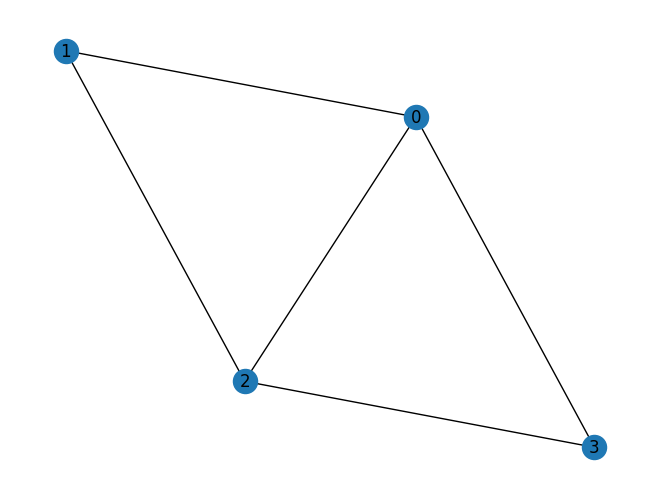

In [2]:
# Construire un graphe à partir d'une matrice d'adjacence :
A = np.matrix([
    [0, 1, 1, 1],
    [1, 0, 1, 0], 
    [1, 1, 0, 1],
    [1, 0, 1, 0]],
    dtype=float
)

# Dessiner le graphe correspondant
# Utiliser  nx.from_numpy_array et nx.draw
G = nx.from_numpy_array(A)
nx.draw(G, with_labels=True)
plt.show()



In [3]:
# Récupéer la matrice d'adjacence à partir d'un graphe

matrice = nx.to_numpy_array(G) 

# A compléter ..
# Utiliser  nx.to_numpy_array 

print(matrice)


[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


Pour l'aspect "spectral",, il suffit de comprendre qu'il s'agit simplement de décomposer un signal/audio/image/graphique en une combinaison (généralement, une somme) d'éléments simples (ondelettes, graphlets). 

Pour obtenir certaines propriétés intéressantes d'une telle décomposition, ces éléments simples sont généralement orthogonaux, c'est-à-dire mutuellement linéairement indépendants, et forment donc une base.

Lorsque nous parlons de "spectral" dans le traitement du signal/de l'image, nous faisons référence à la transformée de Fourier, qui nous offre une base particulière (matrice DFT, par exemple scipy.linalg.dft en Python) d'ondes sinusoïdales et cosinusoïdales élémentaires de différentes fréquences, de sorte que nous pouvons représenter notre signal/image comme une somme de ces ondes. 

Mais lorsque nous parlons de graphes et de réseaux neuronaux de graphes (GNN), le terme "spectral" implique une décomposition propre du laplacien du graphe L. Vous pouvez considérer le laplacien du graphe L comme une matrice d'adjacence A normalisée d'une manière particulière, tandis que la décomposition propre est un moyen de trouver ces composantes orthogonales élémentaires qui composent notre graphe.

Intuitivement, le laplacien du graphe montre dans quelles directions et avec quelle fluidité l'"énergie" se diffuse sur un graphe si nous plaçons un "potentiel" au nœud i. Un cas typique d'utilisation du laplacien en mathématiques et en physique est la résolution de la question de savoir comment un signal (une onde) se propage dans un système dynamique. La diffusion est régulière lorsqu'il n'y a pas de changements soudains de valeurs entre les voisins.

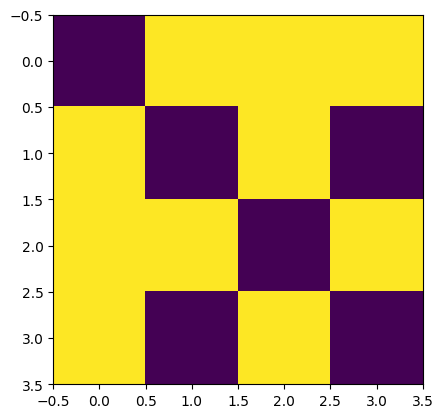

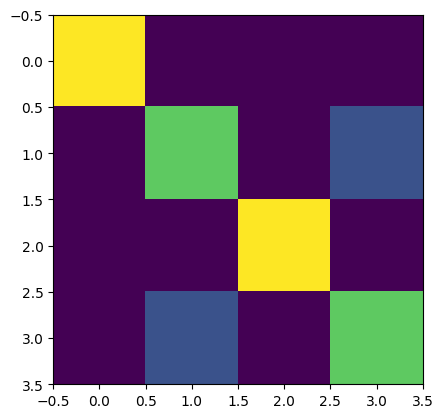

In [4]:
A = nx.to_numpy_array(G)
nb_nodes = G.number_of_nodes()
deg = np.sum(A, axis=1)
D =  np.diag(deg)
L = D - A

# Affichage des matrices
plt.imshow(A)
plt.show()


plt.imshow(L)
plt.show()


#### Laplacien normalisé : pour éviter des valeurs explosant avec des multiplications.

$L_{\text{norm}} = I - D^{-1/2} A D^{-1/2}$

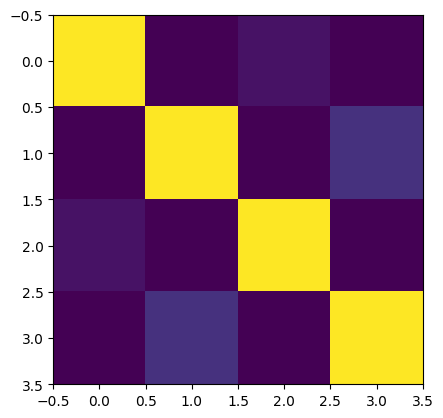

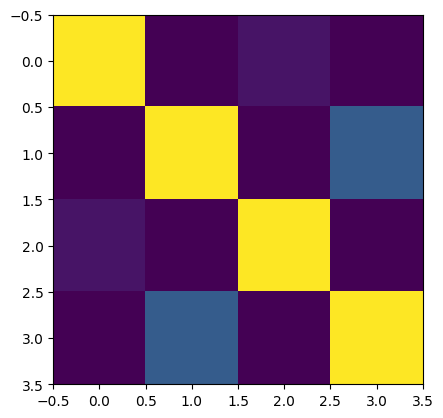

In [5]:
I = np.identity(nb_nodes)

L_norm = I - np.dot(np.linalg.inv(D) ,np.dot(A, np.linalg.inv(D)))

plt.imshow(L_norm)
plt.show()

L_norm_scipy = nx.normalized_laplacian_matrix(G).todense()

plt.imshow(L_norm_scipy)
plt.show()


### Graphe biparti

#### Une première construction du graphe

A partir de l’ensemble des points d’intérêts et des descripteurs définis au TP précédent, créez un graphe biparti entre deux images où chaque noeud de l'image 1 est connecté à un noued de l'iamge 2 avec le coût minimal.


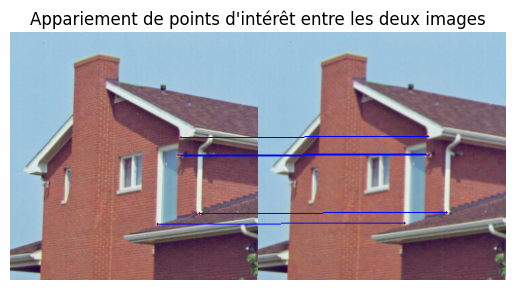

(0, 3, np.float64(1.4142135623730951))
(1, 2, np.float64(1.4142135623730951))
(2, 0, np.float64(1.4142135623730951))
(3, 4, np.float64(1.4142135623730951))
(4, 1, np.float64(1.4142135623730951))


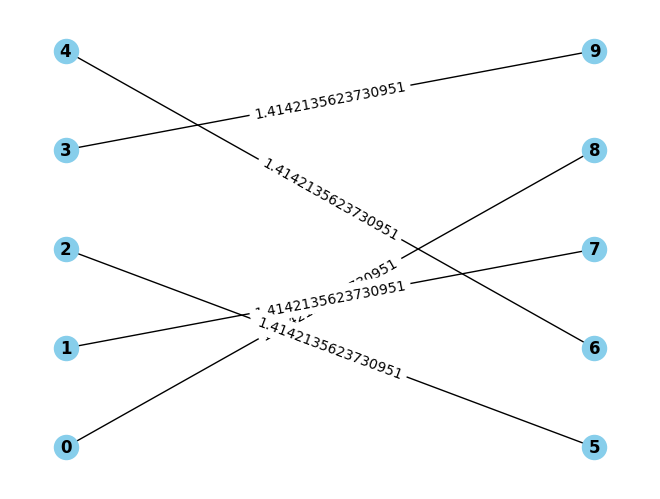

In [6]:
# Modifier la fonction matching pour renvoyer les arcs ainsi que les poids 
from scipy.spatial.distance import euclidean, cdist

def extraire_descripteurs(image_grise, type_detecteur='ORB', pourcentage=0.1):
      # En fonction du type de détecteur / descripteur, renvoyer la liste des points clés et des descripteurs
      if type_detecteur == 'HARRIS':
            harris = cv2.cornerHarris(image_grise, 2, 3, 0.04)
            points_cles = np.argwhere(harris > 0.01 * harris.max())
            points_cles = [cv2.KeyPoint(int(p[1]), int(p[0]), 1) for p in points_cles]      
            descripteurs = None
      elif type_detecteur == 'FAST':
            detecteur = cv2.FastFeatureDetector_create()
            descripteurs = None
            points_cles = detecteur.detect(image_grise, None)
      elif type_detecteur == 'ORB':
            detecteur = cv2.ORB_create(nfeatures=50)
            descripteur = cv2.ORB_create(nfeatures=50)
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'KAZE':
            detecteur = cv2.KAZE_create()
            descripteur = cv2.KAZE_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'AKAZE':
            detecteur = cv2.AKAZE_create()
            descripteur = cv2.AKAZE_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'BRISK':
            detecteur = cv2.BRISK_create()
            descripteur = cv2.BRISK_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'SIFT':
            detecteur = cv2.SIFT_create()
            descripteur = cv2.SIFT_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'GFTT':
            detecteur = cv2.GFTTDetector_create()
            descripteur = None
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'SURF':
            detecteur = cv2.SURF_create()
            descripteur = cv2.SURF_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == "SHI_TOMASI":
            points_cles = cv2.goodFeaturesToTrack(image_grise, 50, 0.01, 10)
            points_cles = [cv2.KeyPoint(int(p[0][0]), int(p[0][1]), 1) for p in points_cles]
            descripteurs = None
      elif type_detecteur == "MOPS":
            detecteur = cv2.MOPS_create()
            descripteur = cv2.MOPS_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      else:
            raise ValueError("Invalid type_detecteur value. Please choose from the given options.")
      
      # On ne garde qu'un pourcentage des points clés
      points_cles = points_cles[:int(pourcentage * len(points_cles))]
      if descripteurs is not None:
            descripteurs = descripteurs[:int(pourcentage * len(descripteurs))]

      return points_cles, descripteurs
  

def detecter_points_interet(image, type_detecteur='ORB', pourcentage=0.1):
        image_grise = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        points_cles, descripteurs = extraire_descripteurs(image_grise, type_detecteur, pourcentage)
        
        image_kp = cv2.drawKeypoints(image, points_cles, None, color=(0, 255, 0))
        
        return points_cles, image_kp


def matching(image1, image2, kp_list1, kp_list2):
    correspondances = []
    kp_list2 = list(kp_list2)
    
    for p1 in kp_list1:
        x1,y1 = p1.pt
        min = np.inf
        for p2 in kp_list2:
            x2,y2 = p2.pt
            euclidean_distance = euclidean((x1,y1), (x2,y2))
            similarite = np.linalg.norm(image1[int(x1),int(y1)] - image2[int(x2),int(y2)])
            dist = euclidean_distance + similarite
            if dist < min:
                min = dist
                index_correspondance = kp_list2.index(p2)
        correspondances.append((kp_list1.index(p1),  index_correspondance, min))
    return correspondances

def trace(img1,img2,kp_list1,kp_list2,correspondances):
    # Redimensionner img2 pour avoir la même hauteur que img1
    hauteur, largeur = img1.shape[:2]
    img2_resized = cv2.resize(img2, (largeur, hauteur))

    # Dessiner des croix sur les points des deux images
    for correspondance in correspondances:
        p1, p2, _ = correspondance
        x1, y1 = kp_list1[p1].pt
        x2, y2 = kp_list2[p2].pt
        cv2.circle(img1, (int(x1), int(y1)), 1, (0, 0, 255), -1)
        cv2.circle(img2_resized, (int(x2), int(y2)), 1, (0, 0, 255), -1)



    # Dessiner des lignes entre les points correspondants sur les deux images
    # Créer une image 'img_combine' avec les deux images, qui servira pour tracer les correspondances
    img_combine = np.hstack((img1, img2_resized))
    
    for correspondance in correspondances:
        p1, p2, _ = correspondance
        x1, y1 = kp_list1[p1].pt
        x2, y2 = kp_list2[p2].pt
        cv2.line(img_combine, (int(x1), int(y1)), (int(x2) + largeur, int(y2)), (255, 0, 0), 1)
    

    # Afficher le résultat
    plt.imshow(cv2.cvtColor(img_combine, cv2.COLOR_BGR2RGB))
    plt.title("Appariement de points d'intérêt entre les deux images")
    plt.axis('off')  # Désactiver les axes
    plt.show()


# Charger les images
image1 = cv2.imread('images/house1.ppm')
kp_list1,image_kp1 = detecter_points_interet(image1)

# Transformation de l'image pour le matching
#tform = AffineTransform(scale=(0.8, 0.8), rotation=0.2, translation=(20, -10))
#image2 = (warp(image1, tform.inverse, output_shape=image1.shape[:2]) * 255).astype(np.uint8)
image2 = cv2.imread('images/house2.ppm')
kp_list2,image_kp2 = detecter_points_interet(image2)

#plot(image_kp1,image_kp2,"ORB")

# Trouver les correspondances entre les deux ensembles de points clés
correspondances = matching(image1, image2, kp_list1, kp_list2)
trace(image1,image2,kp_list1,kp_list2,correspondances)



# Création d'un graphe biparti avec poids sur les arêtes
G = nx.Graph()

# Ajout des sommets dans les ensembles correspondants
G.add_nodes_from(range(len(kp_list1)), bipartite=0)
G.add_nodes_from(range(len(kp_list1), len(kp_list1) + len(kp_list2)), bipartite=1)



# Ajout des arêtes avec poids entre les ensembles basées sur les correspondances
# A compléter ..

for correspondance in correspondances:
    print(correspondance)
    G.add_edge(correspondance[0], correspondance[1] + len(correspondances), weight=correspondance[2])





# Affichage du graphe biparti avec poids sur les arêtes et espacement global

pos = nx.bipartite_layout(G, range(len(kp_list1)))


# Augmentation de l'espacement global entre les ensembles
pos = {node:(x, y*1.5) for node, (x, y) in pos.items()}

# Affichage du graphe biparti avec poids sur les arêtes
# A compléter ..

nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue')

# Affichage des poids sur les arêtes avec ajustement de position
# A compléter ..

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.show()







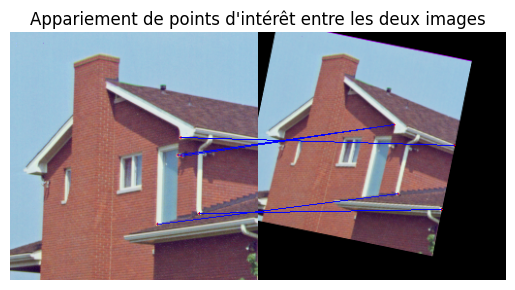

(0, 4, np.float64(128.60236976066165))
(1, 0, np.float64(97.89821415837856))
(2, 1, np.float64(64.70023195814721))
(3, 0, np.float64(102.75137456931913))
(4, 3, np.float64(102.01604147454324))


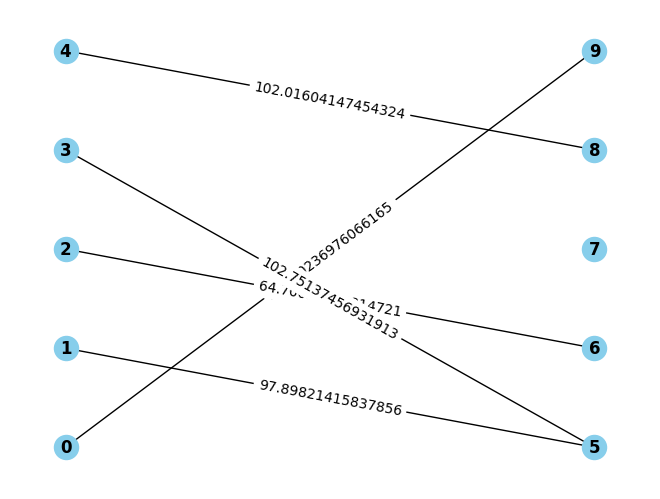

In [7]:
image1 = cv2.imread('images/house1.ppm')
kp_list1,_ = detecter_points_interet(image1)

tform = AffineTransform(scale=(0.8, 0.8), rotation=0.2, translation=(20, -10))
image2 = (warp(image1, tform.inverse, output_shape=image1.shape[:2]) * 255).astype(np.uint8)
kp_list2,_ = detecter_points_interet(image2)

correspondances = matching(image1, image2, kp_list1, kp_list2)
trace(image1,image2,kp_list1,kp_list2,correspondances)
G = nx.Graph()

G.add_nodes_from(range(len(kp_list1)), bipartite=0)
G.add_nodes_from(range(len(kp_list1), len(kp_list1) + len(kp_list2)), bipartite=1)

for correspondance in correspondances:
    print(correspondance)
    G.add_edge(correspondance[0], correspondance[1] + len(correspondances), weight=correspondance[2])
    
pos = nx.bipartite_layout(G, range(len(kp_list1)))

pos = {node:(x, y*1.5) for node, (x, y) in pos.items()}

nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue')

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.show()




#### Une seconde construction du graphe


A partir de l’ensemble des points d’intérêts et des descripteurs définis au TP précédent, créez un graphe où chaque sommet représente un point d’intérêt et une arête (i, j) existe entre les points i et j si j est un des 5 plus proche voisin de i et vice versa.

La distance considérée pour cette construction est la distance spatiale entre les coordonnées des points.


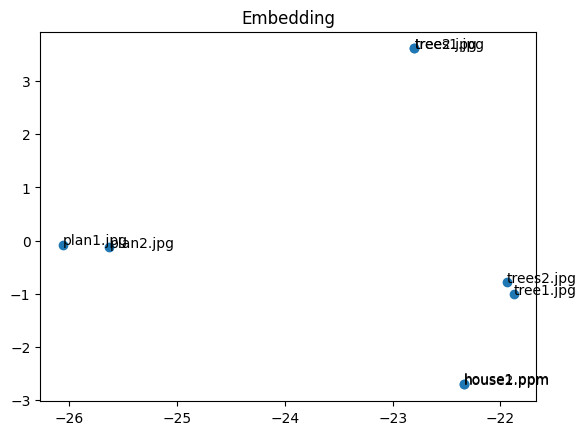

In [8]:
import os 
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def createDictionary(name,orb,orbDetect):
    img = cv2.imread(name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orbDetect:
        kp = orb.detect(gray, None)
        kp, desc = orb.compute(gray, kp)
    else:
        kp, desc = orb.detectAndCompute(gray, None)

    return {'name':name,'kp':kp,'desc':desc}

def align_cost(desc1,desc2):
    distance=cdist(desc1,desc2,metric='hamming')
    return np.asarray(distance)

def distKeyPoints(ptDesc1,ptDesc2):      
    distance=align_cost(ptDesc1['desc'],ptDesc2['desc'])
    
    row_ind,col_ind= linear_sum_assignment(distance)
    cost = distance[row_ind,col_ind].sum()
    return cost,row_ind,col_ind


def loadNames(file):
    l=[]
    with open(file,"r") as f:
        l=f.readlines()
    l=[n[:-1] for n in l]
    return l

    
def display(distance,names):
    nb=distance.shape[0]
    ZeroDiag= np.eye(nb,dtype=int)-np.ones((nb,nb),dtype=int)
    S=-.5*np.dot(np.dot(ZeroDiag,distance),ZeroDiag)
    u, s, vh = np.linalg.svd(S, full_matrices=True)
    s[2:]=0
    Pts=(u*np.sqrt(s))[:,0:2]
    x,y=Pts.T
       
    plt.title("Embedding")
    plt.scatter(x,y)
    for i in range(nb):
        plt.text(Pts[i,0], Pts[i,1], names[i])
    
    plt.show() 
    return



orb = cv2.ORB_create(nfeatures=50)
files=loadNames('list.txt')
PtDesc=[createDictionary(name,orb,False) for name in files]

nb=len(files)
distances=np.asarray([[distKeyPoints(PtDesc[i],PtDesc[j])[0] for i in range(nb) ] for j in range(nb)])
names=[os.path.basename(file) for file in files]
display(distances,names)


# Ajout des arêtes entre les ensembles basées sur les correspondances


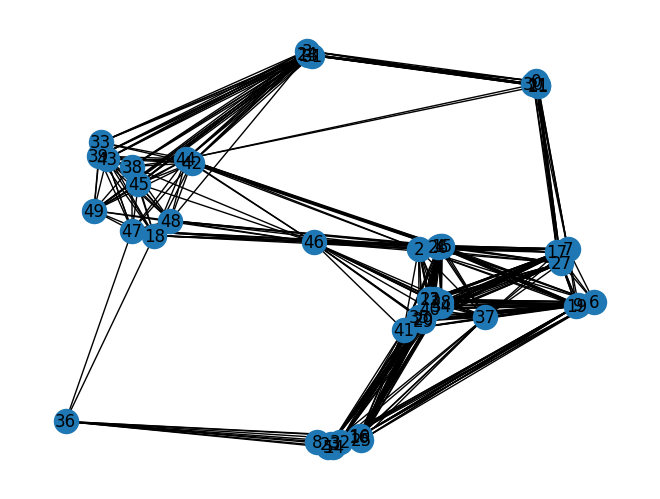

In [9]:
def createGraph(ptDesc):
    kp=ptDesc['kp']
    coords=[kp[i].pt for i in range(len(kp))]

    bf=cv2.BFMatcher()
    matches =bf.knnMatch(np.asarray(coords,np.float32),np.asarray(coords,np.float32),27)
    train=[[(k.trainIdx,k.distance) for k in matches[i]] for i in range(len(matches))]
    mutualMatch=[ [ k for k in train[i] if k[0]!= i and i in [ l[0] for l in train[k[0]]]] for i in range(len(matches))]

    G=nx.Graph()
    G.add_nodes_from(range(len(kp)))
    for i in range(len(matches)):
        edges = [[i,k[0],k[1]] for k in mutualMatch[i] if k[0]<i]
        G.add_weighted_edges_from(edges)  
    return G
   
G=createGraph(PtDesc[0])

kp=PtDesc[0]['kp']
coords=[kp[i].pt for i in range(len(kp))]
nx.draw(G,coords, with_labels=True)

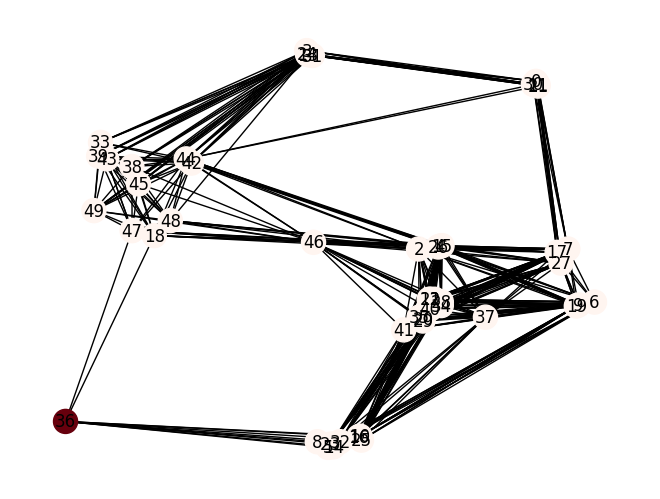

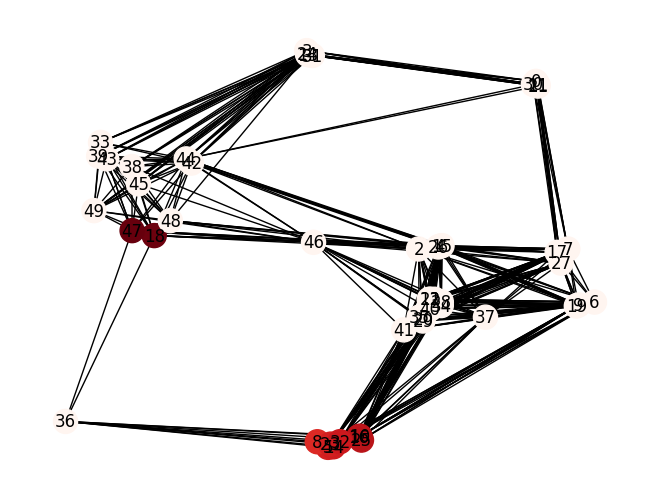

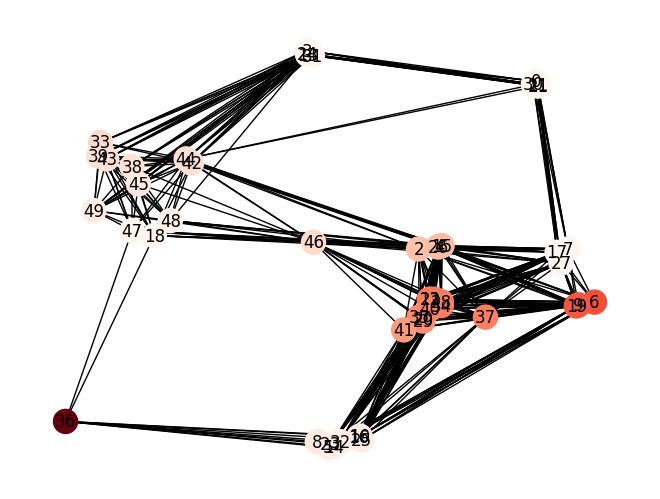

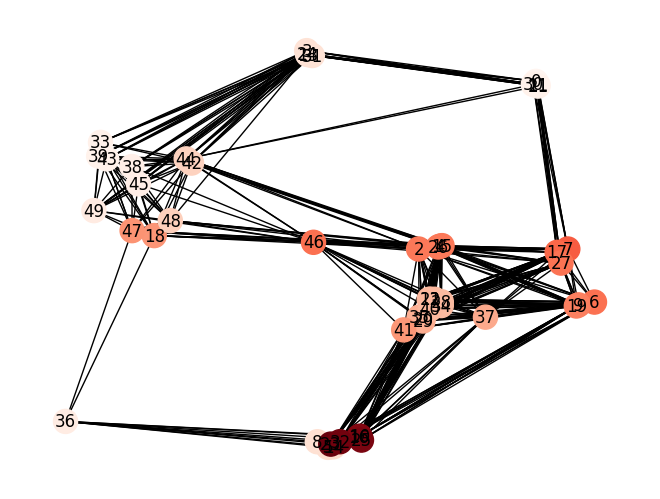

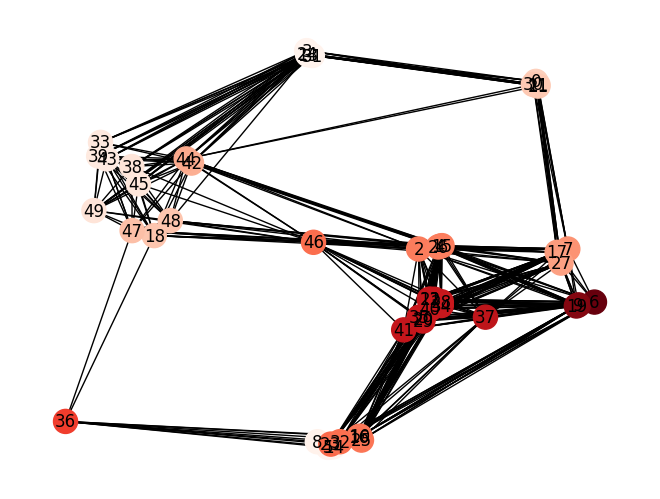

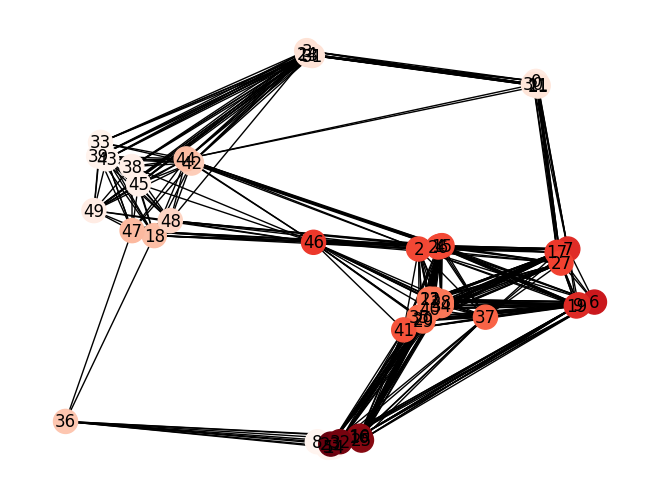

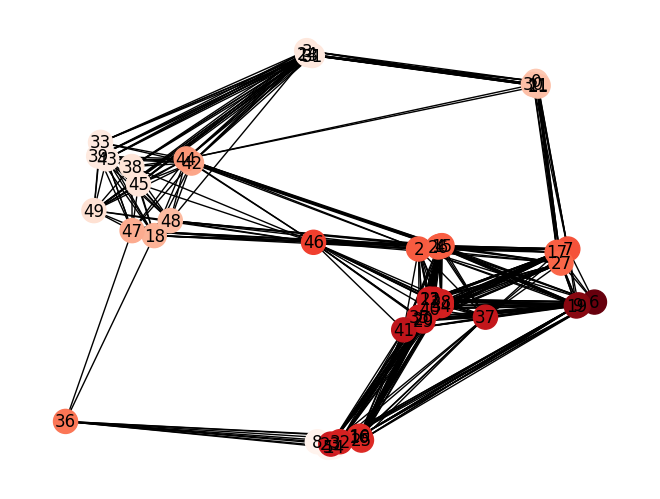

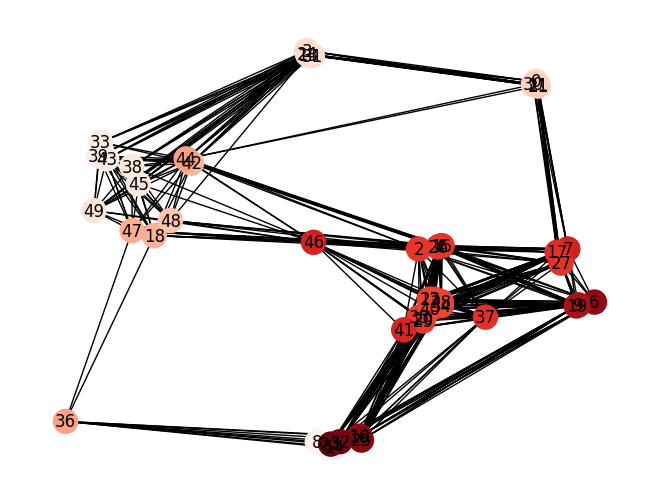

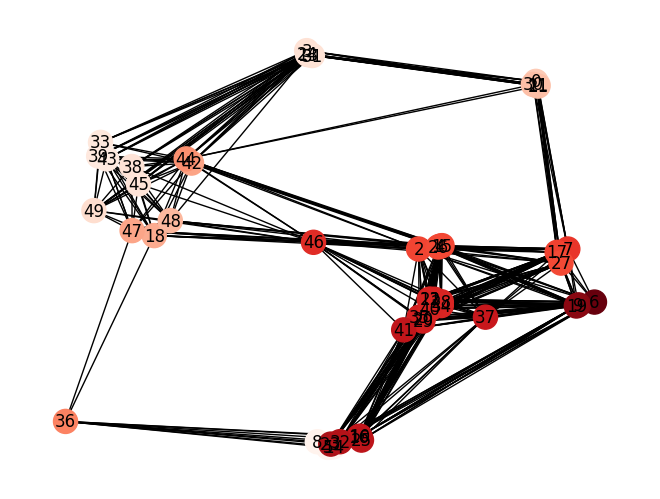

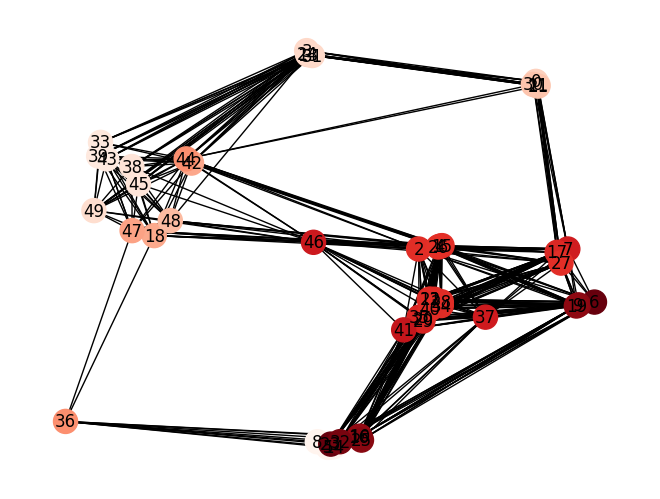

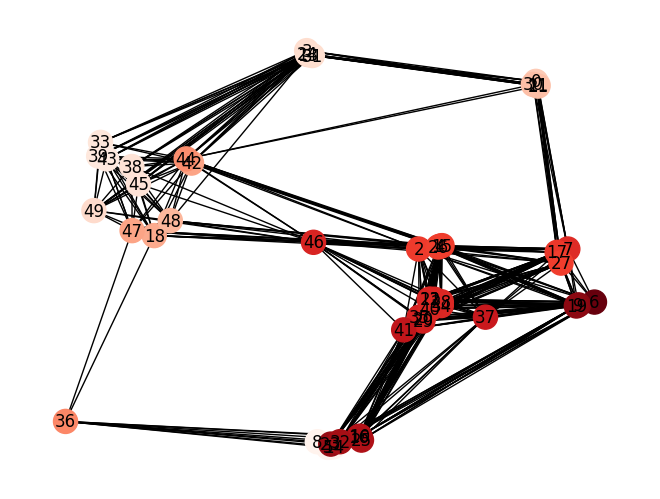

In [10]:
A = nx.adjacency_matrix(G)
start_vector = np.zeros(A.shape[0])
start_vector[np.random.randint(A.shape[0])] = 1


nx.draw(G, coords, node_color=start_vector, cmap=plt.cm.Reds, with_labels=True)
plt.show()

for i in range(10):
    start_vector = A.dot(start_vector)
    nx.draw(G, coords, node_color=start_vector, cmap=plt.cm.Reds, with_labels=True)
    plt.show()



On se propose de construire une première version de la fonction  editDistFromAlign (voir prototype ci-dessous) qui à partir de l’alignement calculé à la question précédente calcule la distance d’édition entre deux graphes. Le fait d’utiliser l’alignement précédent induit que tous les sommets sont substitués (matchés). Les seuls éléments qui peuvent être supprimés ou insérés sont les arêtes.

Le coût de substitution de deux sommets est fixé au coût de substitution
(contenu dans editcosts) fois la distance de Hamming entre les deux descripteurs.

Pour les arêtes :
— les coûts de suppression et d’insertions sont égaux aux coûts contenus
dans editCost.
— le coût de substitution de deux arêtes est fixé comme suit :

$cout =\frac{|d_1 − d_2 |}{d_1+d_2}∗edge~substitution~cost$


où $d_1$ et $d_2$ représentent les distances associées aux deux arêtes. 
Les règles à partir de l’alignement sont les suivantes pour deux sommets
adjacents i et j de G 1 :

* Si i et j sont respectivement substitués par f i et f j et si f i et f j ne sont
pas adjacents il faut ajouter le coût de suppression de (i, j).

* Si f i est adjacent à f j , il faut ajouter le coût de substitution d’arêtes.
De même pour une arête (f i , f j ) de G 2 où f i et f j sont respectivement associés
à i et j, il faut ajouter le coût d’insertion d’une arête si (i, j) n’est pas une
arête de G 1 . Le coût de substitution a déjà été considéré lorsque l’on a examiné
l’arête (i, j) lors du parcours des arêtes de G 1 (items précédent).

Complétez le code de la fonction editDistFromAlign pour calculer le coût lié aux éditions d’arêtes et ajoutez le au coût des éditions de sommets. La
fonction renvoie ce résultat, le main se contentant de l’afficher.
Testez l’évolution de l’affichage des images sous forme d’un nuage de point
(reprendre la question précédente).

In [11]:
def orderedEdge(n,m):
    if(n<m):
        return (n,m)
    return (m,n)

def editDistFromAlign(G1,G2,ptDesc1,ptDesc2,editCosts):
    dist,rowInd,colInd=distKeyPoints(ptDesc1,ptDesc2)
    mapping=list(colInd)
    
    max_val = max(mapping)
    invMapping = [-1] * (max_val + 1)
    for idx,val in enumerate(mapping):
        invMapping[val] = idx
    
    cost=editCosts['nodeSubs']*dist
    
    e1=set(nx.edges(G1))
    e2=set(nx.edges(G2))
    
    e1line2 = set()
    e2line1 = set()

    for i in range(len(rowInd)):
        e1line2.add(orderedEdge(rowInd[i],colInd[i]))
        e2line1.add(orderedEdge(colInd[i],rowInd[i]))

    
    d1 = e1 - e1line2
    d2 = e2line1 - e2
    cost += editCosts['edgeSubs']*(len(d1)+len(d2))
    cost += editCosts['edgeDel']*len(d1)
    cost += editCosts['edgeIns']*len(d2)
      
    return cost

costs={'nodeSubs':1,'nodeIns':1,'nodeDel':1,'edgeSubs':1,'edgeIns':1,'edgeDel':1}
G1=createGraph(PtDesc[0])
G2=createGraph(PtDesc[2])
print(G1[1][20])
cost=editDistFromAlign(G1,G2,PtDesc[0],PtDesc[1],costs)

{'weight': 7.5286078453063965}


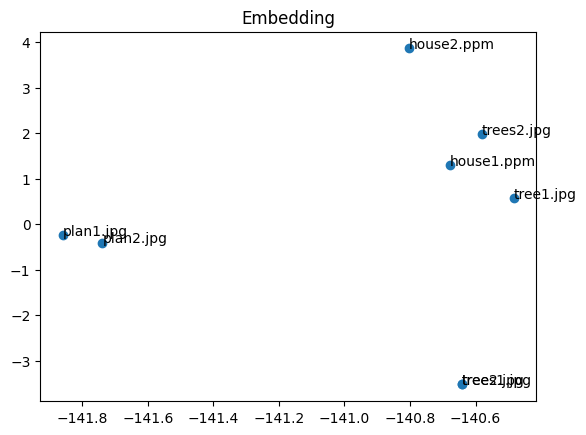

In [12]:
nb=len(files)
Graphs=[createGraph(PtDesc[i]) for i in range(nb)]
distances=np.asarray([[editDistFromAlign(Graphs[i],Graphs[j],PtDesc[i],PtDesc[j],costs) for i in range(nb) ] for j in range(nb)])
names=[os.path.basename(file) for file in files]
display(distances,names)

In [13]:
orb = cv2.ORB_create(edgeThreshold=0,nfeatures=50)
files=loadNames('list.txt')
Graphs=[createDictionary(name,orb,False) for name in files]
costs={'nodeSubs':1,'nodeIns':1,'nodeDel':1,'edgeSubs':1,'edgeIns':1,'edgeDel':1}

# Bonus : Classification d'images

Programme Python pour tester et comparer les performances de trois des techniques d'extraction de caractéristiques d'images les plus populaires :


<br>

    SIFT (Scale-Invariant Feature Transform) 
    SURF (Speeded Up Robust Features)
    HOG (Histogram of Oriented Gradients)

Le programme extrait d'abord les caractéristiques des images en utilisant ces 4 techniques, puis entraîne un Classificateur de Forêt Aléatoire et un Sigmoid à 2 couches et compare ensuite leur précision respective.


## Remarque : je n'ai pas utilisé SURF car j'ai eu des problème de compatibilité entre version 

In [14]:
# Import the required libraries
import os
import cv2
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#from mahotas.features import surf as SURF
DATA = "data"
PATH = os.path.abspath('')
SAMPLES = os.listdir(f'{PATH}/{DATA}')

SIFT = cv2.SIFT_create(nfeatures=400)
HOG = cv2.HOGDescriptor()



In [15]:
def get_descriptors(sample, tech):
    images = os.listdir(f"{PATH}/{DATA}/{sample}")
    images = [f"{PATH}/{DATA}/{sample}/{name}" for name in images]
    descriptors = []
    
    for n, img in enumerate(images):
        img_rgb = cv2.imread(img)
        if tech == 'sift':
            img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
            kps, des = SIFT.detectAndCompute(img_gray, None)
            des = np.mean(des, axis=0)
        elif tech == 'surf':
            img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
          #  des = SURF.surf(img_gray)
           # des = np.mean(des, axis=0)
        elif tech == 'hog':
            img_rgb = cv2.resize(img_rgb, (128, 128))
            img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
            des = HOG.compute(img_gray)
        descriptors.append(des)        
    return descriptors

In [16]:
# Computing the descriptors

Data = {'sift': None, #'surf': None,
        'hog': None}

for model in Data:
    data = []

    for sample in SAMPLES:
        desc = get_descriptors(sample, model)
        data += desc

    Data[model] = np.array(data)
    
    print("Data extracted successfully for", model.upper())

Data extracted successfully for SIFT
Data extracted successfully for HOG


In [17]:
# Labels for the DataSet

labels = np.zeros(606)

labels[0:202] = 0
labels[202:404] = 1
labels[404:606] = 2

In [18]:
# Splitting DataSet into training (70%) and testing (30%)

DataSet = {'sift': {},# 'surf': {},
           'hog': {}}

for model in Data:
    X_train, X_test, y_train, y_test = train_test_split(Data[model], labels, test_size=0.3, random_state=42)
    DataSet[model]['x_train'] = X_train
    DataSet[model]['x_test'] = X_test
    DataSet[model]['y_train'] = y_train
    DataSet[model]['y_test'] = y_test
    
    print("DataSet splitted successfully for", model.upper())

DataSet splitted successfully for SIFT
DataSet splitted successfully for HOG


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# Initializing the models

Models = {'sift': {}, #'surf': {}, 
          'hog': {}}

for model in Models:
    Models[model]['RFC'] = RandomForestClassifier(n_estimators=100, random_state=42)
    Models[model]['ANN'] = MLPClassifier(hidden_layer_sizes=(100, 100), activation='logistic', random_state=42)
    Models[model]['DT'] = DecisionTreeClassifier(random_state=42, max_depth=10)
    Models[model]['SVM'] = SVC(kernel='linear', random_state=42)
    
    
    print("Models initialized successfully for", model.upper())

Models initialized successfully for SIFT
Models initialized successfully for HOG


In [20]:
# Training RandomForestClassifiers

for model in Models:
    Models[model]['RFC'].fit(DataSet[model]['x_train'], DataSet[model]['y_train'])

In [21]:
# Training ANNs

for model in Models:
    Models[model]['ANN'].fit(DataSet[model]['x_train'], DataSet[model]['y_train'])

/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/n

In [22]:
for model in Models:
    Models[model]['DT'].fit(DataSet[model]['x_train'], DataSet[model]['y_train'])

In [23]:
for model in Models:
    Models[model]['SVM'].fit(DataSet[model]['x_train'], DataSet[model]['y_train'])

In [24]:
# Calculating the accuracy for all models

for model in Models:
    for i in Models[model]:
        y_pred = Models[model][i].predict(DataSet[model]['x_test'])
        acc = accuracy_score(DataSet[model]['y_test'], y_pred)
        
        print(f"{i} Accuracy ({model.upper()}):", acc)
    print()

RFC Accuracy (SIFT): 0.6098901098901099
ANN Accuracy (SIFT): 0.5934065934065934
DT Accuracy (SIFT): 0.5054945054945055
SVM Accuracy (SIFT): 0.5439560439560439

RFC Accuracy (HOG): 0.6043956043956044
ANN Accuracy (HOG): 0.6043956043956044
DT Accuracy (HOG): 0.4175824175824176


/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/noahberneaud/.local/share/virtualenvs/Reconnaissance_forme-OY6G_plP/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/n

SVM Accuracy (HOG): 0.6373626373626373

